<a href="https://colab.research.google.com/github/MMRES-PyBootcamp/MMRES-python-bootcamp2022/blob/main/solved_notebooks/12_misophonia_pytorch_sklearn_solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt

In [2]:
# Load package with its corresponding alias
import pandas as pd

# Reading an Excel SpreadSheet and storing it in as a DataFrame called `df`
df = pd.read_excel('https://github.com/MMRES-PyBootcamp/MMRES-python-bootcamp2022/blob/main/datasets/misophoinia_data.xlsx?raw=true')

Before we can get started, we need to manipulate the data a little bit to make it conform to be able to be processed in pytorch.  
This includes converting some `string` lists into numerical values, e.g. roman letters to numerical values, `"III" -> 3`, or turning yes/no strings to categorical vectors `"si" -> [1, 0]` (and `"no" -> [0, 1]`).  
Further, we need to transform the data into torch tensors.  
Note that there are a large number of different ways of doing this, some more and some less efficient. A rule of thumb in python is to avoid for loops and try to use functions like `map` that are parallelized as much as possible. Here it is not _very_ important since the dataset is very small, but it is something to keep in mind.

In [3]:
tensors = [
    df["Angulo_convexidad"].values,
    df["Angulo_cuelloYtercio"].values,
    df["Subnasal_H"].values,
    df["protusion.mandibular"].values
]

mask = ~np.isnan(tensors[0])

for i, t in enumerate(tensors):
    tensors[i] = torch.tensor(t[mask], dtype=torch.float)

data = torch.stack(tensors).transpose(1,0)
#data = data[:, None] # this is because the second dimension is reserved for channels, which we dont have here
print(data.shape)

torch.Size([123, 4])


We now have 123 datapoints of 4 features at our disposal. We want to map each data point to a probability distribution `(p(misofonia), p(no_misofonia))` consisting of two values. As labels, we use the `"Misofonia"` variables that are given in as `"si"` and `"no"` strings. So we need to transform those into so-called categorical vectors.

In [4]:
# Generate the target labels and transform "si"/"no" to [1,0] and [0,1], corresponding to the probabilities [p(misofonia), p(no_misofonia)]
def sino_to_categorical(string, num_classes=2):
    if string=="si":
        y = 1
    elif string=="no":
        y = 0
    return y #torch.eye(num_classes, dtype=torch.float)[y]

labels = df["Misofonia"].values
labels = labels[mask] # remove nans
labels = torch.tensor(list(map(sino_to_categorical, labels)))
labels = torch.tensor(labels, dtype=torch.long)
print(labels.shape)

torch.Size([123])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


We now have all the ingredients, our `data` and categorical vector `labels`, to train our model.  
PyTorch works best when using their efficient data handlers, for that we need some further processing.  

We also dont want to use all our data for training, but leave some data for testing of the model on data it has not yet seen (during training).

In [5]:
dataset = torch.utils.data.TensorDataset(data, labels) # some torch specific transformations of the data into a TensorDataset

# Split all data into a train and test set
N_data = len(data)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [N_data - 20, 20])

train_dataloader = DataLoader(train_dataset, batch_size=12)  # for efficient processing, you will want to create a DataLoader object
test_dataloader = DataLoader(test_dataset, batch_size=12)

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([12, 4])
Shape of y: torch.Size([12]) torch.int64


In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, 512), # need to set input dimension to size of data (number of features = 4)
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 2) # need to set output to dimension of number of categories (2)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        out = torch.sigmoid(logits)
        return out

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=4, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
)


In [7]:
# check if dimensions match by computing an output
for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)
    break

print(X.shape, y.shape, pred.shape)

torch.Size([12, 4]) torch.Size([12]) torch.Size([12, 2])


In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:
loss_fn(pred, y)

tensor(0.6627, grad_fn=<NllLossBackward0>)

In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 2 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    # compute accuracy
    train_acc = correct/size * 100
    return loss, train_acc

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    test_acc = 100*correct
    print(f"Test Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return test_loss, test_acc

In [11]:
epochs = 20
train_losss, train_accs = [], []
test_losss, test_accs = [], []
for t in range(epochs):
    print(f"Epoch {t+1}")
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(test_dataloader, model, loss_fn)
    train_losss.append(train_loss)
    train_accs.append(train_acc)
    test_losss.append(test_loss)
    test_accs.append(test_acc)
print("Done!")

Epoch 1
Test Error: Accuracy: 35.0%, Avg loss: 0.693147
Epoch 2
Test Error: Accuracy: 35.0%, Avg loss: 0.693147
Epoch 3
Test Error: Accuracy: 35.0%, Avg loss: 0.693147
Epoch 4
Test Error: Accuracy: 35.0%, Avg loss: 0.693147
Epoch 5
Test Error: Accuracy: 35.0%, Avg loss: 0.693147
Epoch 6
Test Error: Accuracy: 35.0%, Avg loss: 0.693147
Epoch 7
Test Error: Accuracy: 35.0%, Avg loss: 0.693147
Epoch 8
Test Error: Accuracy: 35.0%, Avg loss: 0.693147
Epoch 9
Test Error: Accuracy: 35.0%, Avg loss: 0.693147
Epoch 10
Test Error: Accuracy: 35.0%, Avg loss: 0.693147
Epoch 11
Test Error: Accuracy: 35.0%, Avg loss: 0.693147
Epoch 12
Test Error: Accuracy: 35.0%, Avg loss: 0.693147
Epoch 13
Test Error: Accuracy: 35.0%, Avg loss: 0.693147
Epoch 14
Test Error: Accuracy: 35.0%, Avg loss: 0.693147
Epoch 15
Test Error: Accuracy: 35.0%, Avg loss: 0.693147
Epoch 16
Test Error: Accuracy: 35.0%, Avg loss: 0.693147
Epoch 17
Test Error: Accuracy: 35.0%, Avg loss: 0.693147
Epoch 18
Test Error: Accuracy: 35.0%, Av

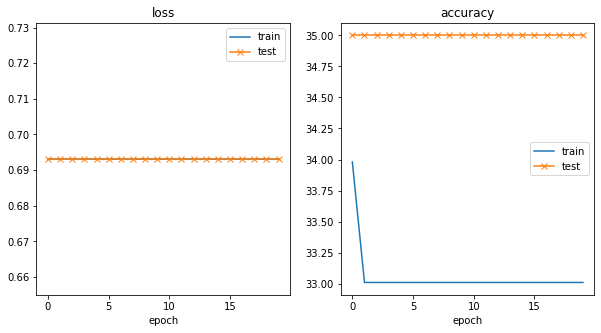

In [12]:
fig, axs = plt.subplots(figsize=(10,5), ncols=2)

ax = axs[0]
ax.plot(train_losss, label="train")
ax.plot(test_losss, "x-", label="test")

ax.set_title("loss")
ax.set_xlabel("epoch")
ax.legend()

ax = axs[1]
ax.plot(train_accs, label="train")
ax.plot(test_accs, "x-", label="test")

ax.set_title("accuracy")
ax.set_xlabel("epoch")
ax.legend()

# PCA and k-means clustering

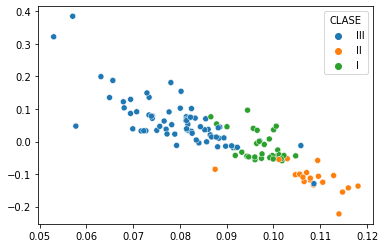

In [13]:
X=df[['Angulo_convexidad','protusion.mandibular', 'Angulo_cuelloYtercio', 'Subnasal_H','Misofonia.dic','CLASE','Misofonia']].dropna()
labels=X['Misofonia']
pca = PCA(n_components=2)
pca.fit(X[['Angulo_convexidad','protusion.mandibular', 'Angulo_cuelloYtercio', 'Subnasal_H']].T)
#pca.components_.shape
sns.scatterplot(x=pca.components_[0],y=pca.components_[1],hue=X['CLASE'])
#reduced_data = pca.fit_transform(X.T)
#sns.scatterplot(reduced_data[0],reduced_data[1])

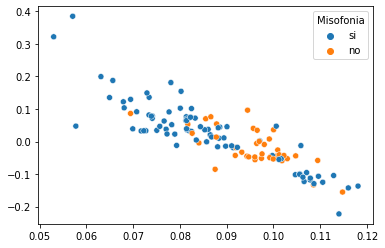

In [14]:
sns.scatterplot(x=pca.components_[0],y=pca.components_[1],hue=X['Misofonia'])


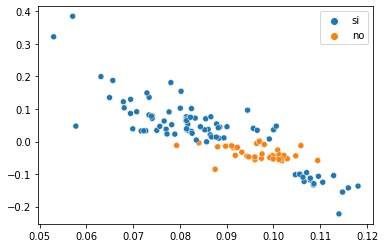

In [15]:
from sklearn import svm
labels=X['Misofonia']
clf = svm.SVC()
clf.fit(pca.components_.T, labels)
pred=clf.predict(pca.components_.T)

sns.scatterplot(x=pca.components_[0],y=pca.components_[1],hue=pred)


In [16]:
pd.crosstab(X['Misofonia'],pred)

col_0,no,si
Misofonia,,
no,27,14
si,11,71
